**Anna Smith**

**GitHub username: acs-233**

**Imperial College London - MSc EDSML - IRP**
# **CNN to predict $\textnormal{BECO}_2\textnormal{N}$ data - Reduced featres and data**

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKeras

In [2]:
from bayareaco2.models.data import fit_scaler, scale_features

## Reading in Data

In [3]:
path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'balanced_daily_avg_BEACO2N.csv'
co2 = pd.read_csv(path)

path = Path.cwd().parent.parent.parent / 'Data' / 'features.csv'
features = pd.read_csv(path)

# Merging data
df = co2.merge(features, on='node_id')

In [4]:
df['node_id'].value_counts()

node_id
44     534
54     534
81     534
22     534
40     534
26     533
14     532
82     532
65     530
80     530
60     530
38     529
41     511
13     489
45     489
39     485
78     461
46     460
64     460
23     457
20     454
63     399
31     391
43     390
61     387
30     386
28     384
21     361
57     353
281    347
286    339
51     336
42     323
55     295
49     291
17     287
24     273
16     271
25     265
4      232
280    215
15     212
Name: count, dtype: int64

In [5]:
df

,Unnamed: 0,node_id,date,timestamp,co2,temp,pressure,rh,year,month,...,avg_pop_dens_50m,avg_pop_dens_100m,avg_pop_dens_200m,avg_pop_dens_300m,avg_pop_dens_500m,avg_pop_dens_1000m,avg_pop_dens_2000m,avg_pop_dens_3000m,avg_pop_dens_4000m,avg_pop_dens_5000m
0,1539,4,2022-01-01,2022-01-01 11:30:00.000000000,444.400204,7.547035,999.754739,60.628520,2022,1,...,5208.800000,5208.800000,5179.744961,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196
1,1540,4,2022-01-02,2022-01-02 11:30:00.000000000,453.541155,8.937224,1001.820275,63.048644,2022,1,...,5208.800000,5208.800000,5179.744961,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196
2,1541,4,2022-01-03,2022-01-03 11:30:00.000000000,441.211655,10.741178,1000.370385,76.591252,2022,1,...,5208.800000,5208.800000,5179.744961,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196
3,1542,4,2022-01-04,2022-01-04 11:30:00.000000000,433.777005,13.741635,1003.960120,80.556825,2022,1,...,5208.800000,5208.800000,5179.744961,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196
4,1543,4,2022-01-05,2022-01-05 11:30:00.000000000,436.049086,14.247229,1002.731049,77.232257,2022,1,...,5208.800000,5208.800000,5179.744961,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17384,43738,286,2023-10-08,2023-10-08 11:30:00.000000000,423.624269,24.253212,1010.376829,46.244989,2023,10,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071
17385,43739,286,2023-10-09,2023-10-09 11:30:00.000000000,416.561727,24.336228,1009.992955,46.518173,2023,10,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071
17386,43740,286,2023-10-10,2023-10-10 11:15:39.130434816,415.588174,24.621320,1008.725354,48.531213,2023,10,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071
17387,43741,286,2023-10-11,2023-10-11 11:30:00.000000000,420.917376,24.556401,1009.965181,38.998069,2023,10,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071


In [6]:
grouped = df.groupby(['node_id', 'date']).size().reset_index(name='count')

# Find the dates that have the maximum overlap between node_ids
date_counts = grouped.groupby('date')['node_id'].nunique().reset_index(name='node_count')
date_counts = date_counts.sort_values(by='node_count', ascending=False)

# Select 212 observations per node_id, prioritizing common dates
balanced_df = pd.DataFrame()
for node in df['node_id'].unique():
    node_data = df[df['node_id'] == node]
    sampled_data = pd.DataFrame()
    for date in date_counts['date']:
        date_data = node_data[node_data['date'] == date]
        if len(date_data) > 0:
            sampled_data = pd.concat([sampled_data, date_data])
            if len(sampled_data) >= 212:
                break
    if len(sampled_data) < 212:
        additional_data = node_data[~node_data['date'].isin(sampled_data['date'])]
        sampled_data = pd.concat([sampled_data, additional_data]).head(212)
    balanced_df = pd.concat([balanced_df, sampled_data])

# Ensure the balanced DataFrame has 212 observations per node_id
balanced_df = balanced_df.groupby('node_id').head(212)

# Reset index for clarity
balanced_df = balanced_df.reset_index(drop=True)

In [7]:
# Defining dependent variable
y = balanced_df['co2'].copy()

In [8]:
# Combining feature labels
feature_vars = features.drop(columns='node_id').columns.to_list()
feature_vars.append('temp')
feature_vars.append('pressure')
feature_vars.append('rh')

In [9]:
node_id = balanced_df['node_id'].copy()

In [10]:
# Defining dependent variables
X = balanced_df[feature_vars].copy()

In [11]:
# Inspecting X -- 123 features
X

,Built_Area_area_50m,Rangeland_area_50m,Trees_area_50m,Water_area_50m,Bare_Ground_area_50m,Crops_area_50m,Flooded_Vegetation_area_50m,Built_Area_area_100m,Rangeland_area_100m,Trees_area_100m,...,avg_pop_dens_300m,avg_pop_dens_500m,avg_pop_dens_1000m,avg_pop_dens_2000m,avg_pop_dens_3000m,avg_pop_dens_4000m,avg_pop_dens_5000m,temp,pressure,rh
0,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196,20.108610,991.665913,63.913319
1,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196,20.583529,990.773206,66.393384
2,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196,20.270209,991.873734,67.674478
3,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196,21.446891,993.545570,62.469767
4,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,4934.744803,4677.358739,4494.435919,4269.319433,4436.773639,5443.439375,6707.038196,22.534963,994.124282,58.030216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,23.970595,1015.734266,43.621617
8900,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,13.994784,1017.085065,23.725279
8901,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,20.202732,1012.102178,52.202900
8902,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,26.383010,1013.902638,44.450178


In [12]:
# Inspecting y
y

0       415.556375
1       414.990369
2       414.297389
3       415.671904
4       426.884710
           ...    
8899    426.028999
8900    461.866939
8901    418.541180
8902    409.660248
8903    449.851581
Name: co2, Length: 8904, dtype: float64

In [13]:
node_id

0         4
1         4
2         4
3         4
4         4
       ... 
8899    286
8900    286
8901    286
8902    286
8903    286
Name: node_id, Length: 8904, dtype: int64

# Preparing Data

In [14]:
# Checking for zero columns
zero_columns = [col for col in X.columns if (X[col] == 0).all()]
print(f"{len(zero_columns)} columns with all zeros:")
zero_columns

18 columns with all zeros:


['Rangeland_area_50m',
 'Bare_Ground_area_50m',
 'Crops_area_50m',
 'Flooded_Vegetation_area_50m',
 'Bare_Ground_area_100m',
 'Crops_area_100m',
 'Flooded_Vegetation_area_100m',
 'Bare_Ground_area_200m',
 'Crops_area_200m',
 'Flooded_Vegetation_area_200m',
 'Bare_Ground_area_300m',
 'Crops_area_300m',
 'Flooded_Vegetation_area_300m',
 'Bare_Ground_area_500m',
 'total_AADT_50m',
 'total_AADT_100m',
 'total_AADT_200m',
 'total_road_length_50m']

In [15]:
# Dropping zero columns
X = X.drop(columns = zero_columns)

In [16]:
# Standardizing the data
scaler = fit_scaler(X)
X_scaled = scale_features(scaler, X)

In [17]:
X_scaled

,Built_Area_area_50m,Trees_area_50m,Water_area_50m,Built_Area_area_100m,Rangeland_area_100m,Trees_area_100m,Water_area_100m,Built_Area_area_200m,Rangeland_area_200m,Trees_area_200m,...,avg_pop_dens_300m,avg_pop_dens_500m,avg_pop_dens_1000m,avg_pop_dens_2000m,avg_pop_dens_3000m,avg_pop_dens_4000m,avg_pop_dens_5000m,temp,pressure,rh
0,0.170129,-0.156174,-0.156174,0.269093,-0.209314,-0.173235,-0.156174,0.338403,-0.320185,-0.203032,...,-0.624445,-0.664113,-0.664673,-0.657608,-0.580208,-0.274573,0.235448,0.134982,-1.756264,0.717717
1,0.170129,-0.156174,-0.156174,0.269093,-0.209314,-0.173235,-0.156174,0.338403,-0.320185,-0.203032,...,-0.624445,-0.664113,-0.664673,-0.657608,-0.580208,-0.274573,0.235448,0.227216,-1.842767,0.917885
2,0.170129,-0.156174,-0.156174,0.269093,-0.209314,-0.173235,-0.156174,0.338403,-0.320185,-0.203032,...,-0.624445,-0.664113,-0.664673,-0.657608,-0.580208,-0.274573,0.235448,0.166366,-1.736126,1.021283
3,0.170129,-0.156174,-0.156174,0.269093,-0.209314,-0.173235,-0.156174,0.338403,-0.320185,-0.203032,...,-0.624445,-0.664113,-0.664673,-0.657608,-0.580208,-0.274573,0.235448,0.394891,-1.574127,0.601207
4,0.170129,-0.156174,-0.156174,0.269093,-0.209314,-0.173235,-0.156174,0.338403,-0.320185,-0.203032,...,-0.624445,-0.664113,-0.664673,-0.657608,-0.580208,-0.274573,0.235448,0.606206,-1.518050,0.242887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,0.170129,-0.156174,-0.156174,0.269093,-0.209314,-0.173235,-0.156174,0.338403,-0.320185,-0.203032,...,1.143188,1.170358,0.956962,0.750806,0.968256,1.024812,1.015097,0.885022,0.575940,-0.920044
8900,0.170129,-0.156174,-0.156174,0.269093,-0.209314,-0.173235,-0.156174,0.338403,-0.320185,-0.203032,...,1.143188,1.170358,0.956962,0.750806,0.968256,1.024812,1.015097,-1.052390,0.706831,-2.525895
8901,0.170129,-0.156174,-0.156174,0.269093,-0.209314,-0.173235,-0.156174,0.338403,-0.320185,-0.203032,...,1.143188,1.170358,0.956962,0.750806,0.968256,1.024812,1.015097,0.153262,0.223994,-0.227441
8902,0.170129,-0.156174,-0.156174,0.269093,-0.209314,-0.173235,-0.156174,0.338403,-0.320185,-0.203032,...,1.143188,1.170358,0.956962,0.750806,0.968256,1.024812,1.015097,1.353539,0.398457,-0.853170


In [19]:
selected_features = ['temp', 'pressure', 'rh', 'Trees_area_50m', 'total_road_length_1000m',
       'total_road_length_200m', 'Built_Area_area_2000m', 'total_AADT_3000m',
       'Flooded_Vegetation_area_1000m', 'Industrial_area_5000m',
       'avg_ndvi_50m']

In [20]:
X_scaled = X_scaled[selected_features]

In [21]:
X_scaled['node_id'] = node_id

/var/folders/b6/v8y7_2cd1mq0mw5t0jtmr6p80000gn/T/ipykernel_38504/702592024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_scaled['node_id'] = node_id


In [22]:
#X_values = X_scaled.values
y_values = y.values

In [23]:
X_scaled.shape

(8904, 12)

In [25]:
feature_columns = [col for col in X_scaled.columns if col != 'node_id']

X_reshaped = np.zeros((212, 42, 11))
y_reshaped = np.zeros((212, 42))

# Loop through each unique node_id to fill the reshaped arrays
for i, node_id in enumerate(X_scaled['node_id'].unique()):
    # Extract the data and target values for the current node_id
    node_data = X_scaled[X_scaled['node_id'] == node_id][feature_columns].values
    node_target = y_values[X_scaled['node_id'] == node_id]
    
    # Reshape and store the data in the appropriate slices of the arrays
    X_reshaped[:, i, :] = node_data
    y_reshaped[:, i] = node_target

# Verify the shapes
print(X_reshaped.shape)  # Should print (212, 42, 105)
print(y_reshaped.shape)  # Should print (212, 42)

(212, 42, 11)
(212, 42)


In [26]:
X_scaled

,temp,pressure,rh,Trees_area_50m,total_road_length_1000m,total_road_length_200m,Built_Area_area_2000m,total_AADT_3000m,Flooded_Vegetation_area_1000m,Industrial_area_5000m,avg_ndvi_50m,node_id
0,0.134982,-1.756264,0.717717,-0.156174,0.889995,1.816826,0.882154,-0.243635,-0.164377,-0.976593,1.480147,4
1,0.227216,-1.842767,0.917885,-0.156174,0.889995,1.816826,0.882154,-0.243635,-0.164377,-0.976593,1.480147,4
2,0.166366,-1.736126,1.021283,-0.156174,0.889995,1.816826,0.882154,-0.243635,-0.164377,-0.976593,1.480147,4
3,0.394891,-1.574127,0.601207,-0.156174,0.889995,1.816826,0.882154,-0.243635,-0.164377,-0.976593,1.480147,4
4,0.606206,-1.518050,0.242887,-0.156174,0.889995,1.816826,0.882154,-0.243635,-0.164377,-0.976593,1.480147,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8899,0.885022,0.575940,-0.920044,-0.156174,1.676289,-0.409114,0.789754,1.223132,-0.164377,-0.111819,0.243271,286
8900,-1.052390,0.706831,-2.525895,-0.156174,1.676289,-0.409114,0.789754,1.223132,-0.164377,-0.111819,0.243271,286
8901,0.153262,0.223994,-0.227441,-0.156174,1.676289,-0.409114,0.789754,1.223132,-0.164377,-0.111819,0.243271,286
8902,1.353539,0.398457,-0.853170,-0.156174,1.676289,-0.409114,0.789754,1.223132,-0.164377,-0.111819,0.243271,286


In [27]:
y_reshaped

array([[415.55637546, 413.00197642, 414.05308365, ..., 434.50298396,
        412.51073345, 412.48594289],
       [414.99036911, 414.17082886, 414.65689571, ..., 429.06193641,
        412.27765821, 411.77540255],
       [414.29738883, 414.44710232, 414.96641645, ..., 440.38994161,
        410.17805276, 410.59248223],
       ...,
       [436.99086311, 422.37926539, 458.4098478 , ..., 415.91269718,
        447.30769247, 418.54118004],
       [438.65048087, 427.74712856, 424.27294049, ..., 415.71738419,
        485.64309253, 409.66024835],
       [429.9910517 , 450.88101659, 451.51926845, ..., 416.70735423,
        427.92958341, 449.851581  ]])

In [28]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [30]:
print(f"Full training set shape: {X_train_full.shape}")
print(f"Full testting set shape: {X_test.shape}")
print(f"Training set length: {X_train.shape}")
print(f"Validation set length: {X_val.shape}")

Full training set shape: (169, 42, 11)
Full testting set shape: (43, 42, 11)
Training set length: (135, 42, 11)
Validation set length: (34, 42, 11)


## Tuning Hyperparameters

In [31]:
# def create_model(dropout_rate=0.2, batch_size=32):
#     model = Sequential([
#         Conv1D(64, 3, activation='relu', input_shape=(X_values.shape[1], 1)),
#         BatchNormalization(),
#         MaxPooling1D(2),
#         Dropout(dropout_rate),

#         Conv1D(128, 3, activation='relu'),
#         BatchNormalization(),
#         MaxPooling1D(2),
#         Dropout(dropout_rate),

#         Flatten(),
#         Dense(128, activation='relu'),
#         BatchNormalization(),
#         Dropout(dropout_rate),

#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
#     return model

In [32]:
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasRegressor

# # Create KerasRegressor for GridSearchCV
# model = KerasRegressor(model=create_model, epochs=40, batch_size=32, verbose=2)

# # Define the parameter grid
# param_grid = {
#     #'model__dropout_rate': [0.1, 0.2, 0.3, 0.4],  # Example choices for dropout rate
#     'model__batch_size': [16, 32, 64, 128]  # Example choices for batch size
# }

# # Perform GridSearchCV
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)
# grid_result = grid.fit(X_train, y_train)

# # Print results
# print(f"Best MSE: {grid_result.best_score_} using {grid_result.best_params_}")

In [33]:
# # Calculate R² score
# r2 = r2_score(y_test, y_pred)
# print(f"R² score: {r2}")
# R² score: 0.4811709141224543

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
# print(f"RMSE: {rmse}")
#RMSE: 15.237399927968886

## Training Conv1D CNN

In [34]:
X_reshaped.shape

(212, 42, 11)

In [35]:
input_shape = (X_train.shape[1:])

In [43]:
# Define the model
model = Sequential([
    Input(shape=input_shape),
    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(42)  # Output layer for regression
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 40, 64)         │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 18, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 42)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,162 (707.66 KB)

 Trainable params: 180,522 (705.16 KB)

 Non-trainable params: 640 (2.50 KB)

In [44]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

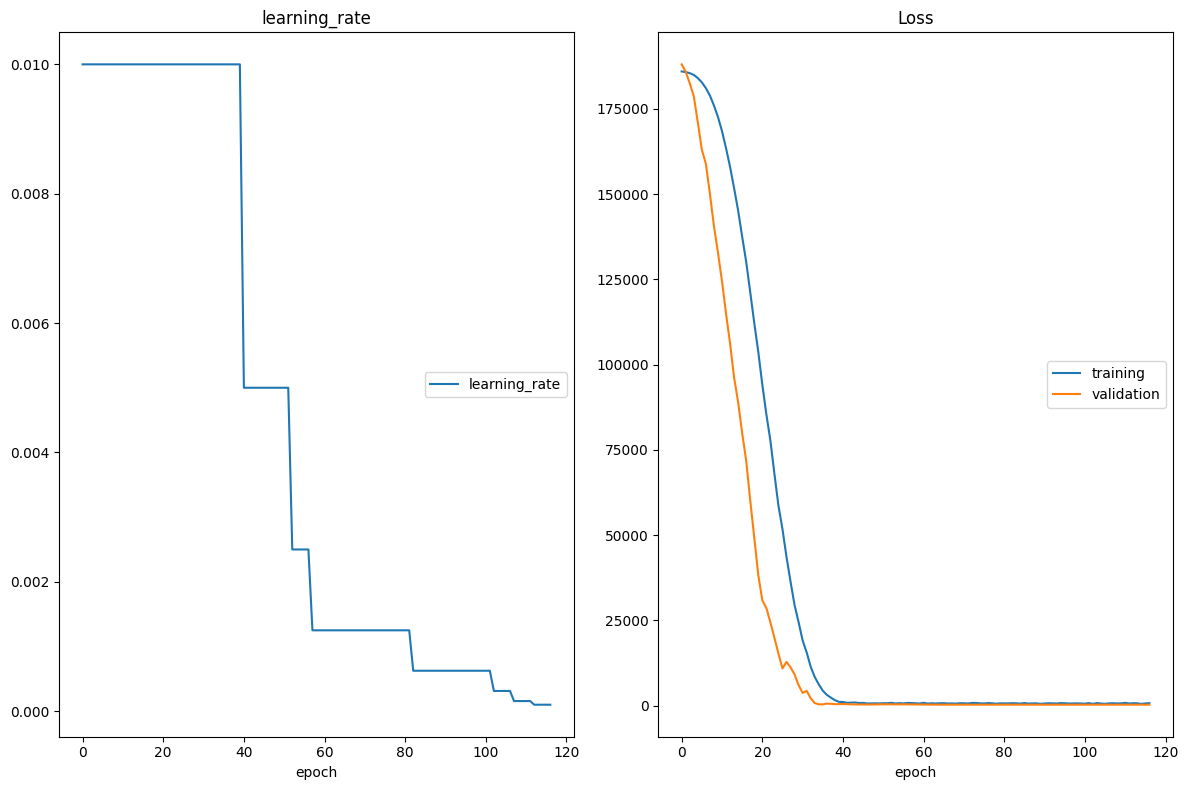

learning_rate
	learning_rate    	 (min:    0.000, max:    0.010, cur:    0.000)
Loss
	training         	 (min:  512.116, max: 185957.078, cur:  714.909)
	validation       	 (min:  270.689, max: 188041.672, cur:  275.932)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 745.2864 - val_loss: 275.9322 - learning_rate: 1.0000e-04


In [45]:
# Compile the model
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, 
              loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint('cnn_reshaped_model_improving.keras', monitor='val_loss', save_best_only=True)

plot_losses = PlotLossesKeras()

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr, checkpoint, plot_losses])

In [46]:
# Make predictions on the test set
y_pred_val = model.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [47]:
y_pred_val.shape

(34, 42)

In [48]:
# Flatten y_val and y_pred_val for consistency
#y_val_flat = y_val.flatten()
#y_pred_val_flat = y_pred_val.flatten()

# Calculate RMSE
rmse_value = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE: {rmse_value:.2f}")

# Calculate R² score using sklearn
r2 = r2_score(y_val, y_pred_val)
print(f"R² score: {r2:.2f}")

RMSE: 14.90
R² score: 0.31


In [49]:
# # Make predictions on the test set
y_pred_test = model.predict(X_test)

# # Calculate RMSE
rmse_value = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {rmse_value:.2f}")

# # Calculate R² score using sklearn
r2 = r2_score(y_test, y_pred_test)
print(f"R² score: {r2:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE: 17.31
R² score: 0.20


## Training on Full Training Set

In [50]:
# Define the model
final_model = Sequential([
    Input(shape=input_shape),
    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(42)  # Output layer for regression
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 40, 64)         │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 18, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 42)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,208 (2.07 MB)

 Trainable params: 180,522 (705.16 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 361,046 (1.38 MB)

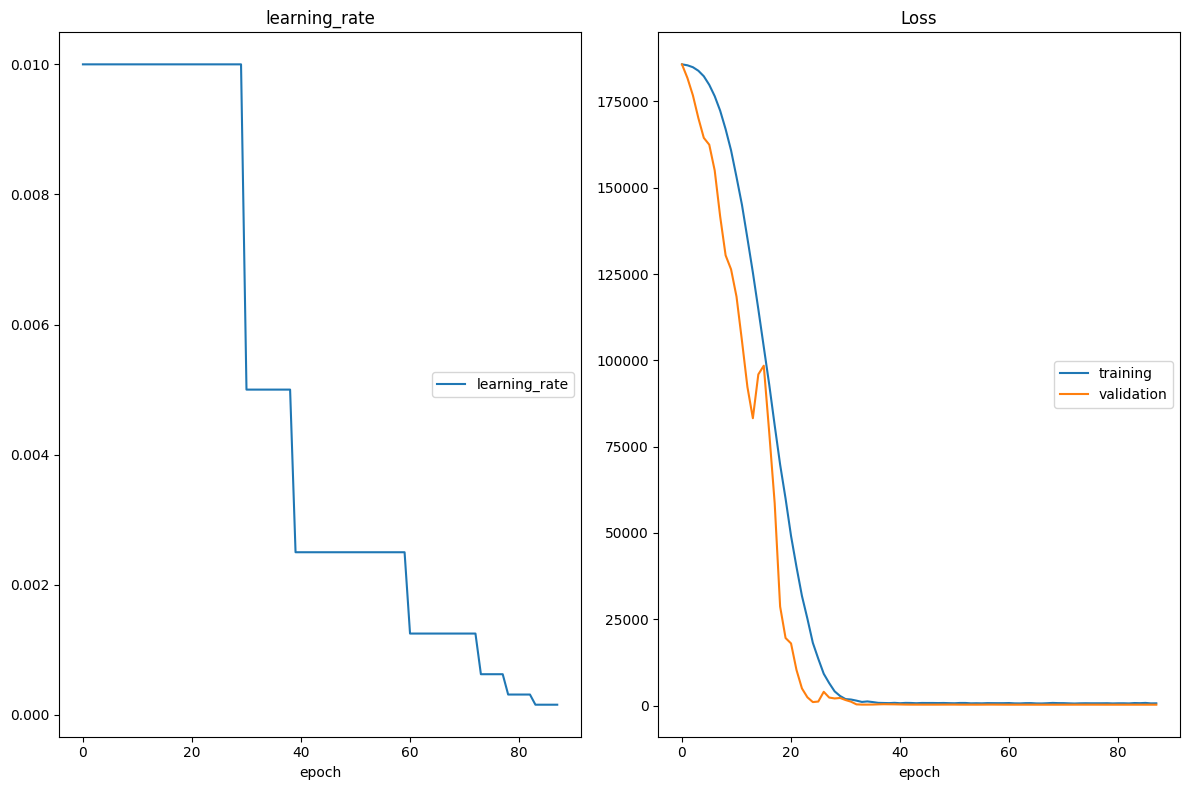

learning_rate
	learning_rate    	 (min:    0.000, max:    0.010, cur:    0.000)
Loss
	training         	 (min:  598.777, max: 185749.000, cur:  654.993)
	validation       	 (min:  253.184, max: 185732.641, cur:  255.574)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 644.3502 - val_loss: 255.5744 - learning_rate: 1.5625e-04


In [51]:
# Compile the model
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.01)
final_model.compile(optimizer=optimizer, 
              loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint('cnn_reshaped_model_improving.keras', monitor='val_loss', save_best_only=True)

plot_losses = PlotLossesKeras()

# Train the model
history = final_model.fit(X_train_full, y_train_full, epochs=150, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr, checkpoint, plot_losses])



In [52]:
# # Make predictions on the test set
y_pred_test = final_model.predict(X_test)

# # Calculate RMSE
rmse_value = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {rmse_value:.2f}")

# # Calculate R² score using sklearn
r2 = r2_score(y_test, y_pred_test)
print(f"R² score: {r2:.2f}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x33c6316c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE: 17.54
R² score: 0.25
